# The Kalman filter and smoother

The Kalman filter and smoother are a set of equations which efficiently compute the posterior distribution over the latent states of a linear state space model given some observed data. The Kalman equations do not carry out any learning. The parameters of the model are assumed to be known and the goal is to infer the posterior over latent states. This page presents the filtering and smoothing equations, together with a few demos.

## Model definition

Suppose we have a linear dynamical system evolving according to the rules

$$\begin{align}
\mathbf{x}_{t + 1} &= \mathbf{A}\mathbf{x}_t + \mathbf{w}_t, && \text{ where } \mathbf{w}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}), \\
      \mathbf{y}_t &= \mathbf{C}\mathbf{x}_t + \mathbf{v}_t, && \text{ where } \mathbf{v}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}).
\end{align}$$

and $\mathbf{x}_1 \sim \mathcal{N}(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)$. We assume that $\mathbf{x}_1$, $\mathbf{w}_t$ and $\mathbf{v}_t$ are independent. Note that all random variables above are either Gaussians or linear transformations of Gaussians, and are therefore all Gaussian. From the assumptions we also have the following independence relations

$$\begin{align}
\mathbf{x}_{t + 1} &\perp \mathbf{y}_{1:t}, \mathbf{x}_{1:t-1} | \mathbf{x}_t, \\
\mathbf{x}_{t} &\perp \mathbf{y}_{t' \geq t + 1}, \mathbf{y}_{t' > t + 1} | \mathbf{x}_{t + 1}, \\
\mathbf{y}_t &\perp \mathbf{y}_{t' \neq t}, \mathbf{x}_{t' \neq t} | \mathbf{x}_t.
\end{align}$$

These independence relations facilitate the computation of associated probability distriubtions we will show below. Before we do that though, let's sample some data from the model. The helper function `sample_trajectory` below samples a single $\mathbf{x}, \mathbf{y}$ trajectory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

In [2]:
def sample_trajectory(m0, S0, A, Q, C, R, num_points):
    
    x = np.random.multivariate_normal(mean=m0, cov=S0)
    y = np.random.multivariate_normal(mean=np.dot(C, x), cov=R)
    
    x_ = np.array([x])
    y_ = np.array([y])
    
    for i in range(num_points - 1):
        
        x = np.random.multivariate_normal(mean=np.dot(A, x), cov=Q)
        y = np.random.multivariate_normal(mean=np.dot(C, x), cov=R)
        
        x_ = np.concatenate([x_[:], x[None, :]], axis=0)
        y_ = np.concatenate([y_[:], y[None, :]], axis=0)
    
    return x_, y_

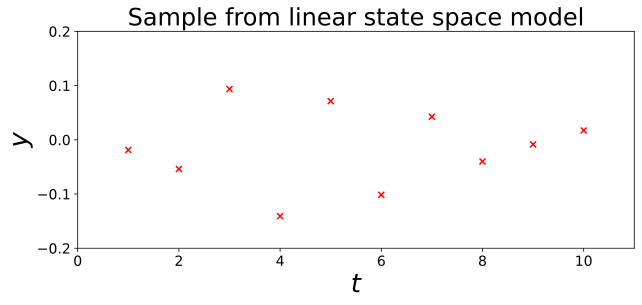

In [3]:
# Dimensions of the latent and observed spaces
x_dim = 3
y_dim = 1

# Initial distribution matrices
m0 = np.zeros(x_dim,)
S0 = 1e-1 * np.eye(x_dim)

# Set the random seed for comparable figures
np.random.seed(0)

# Define matrices A, Q (dynamics)
A = (2 * np.random.rand(x_dim, x_dim) - 1) / x_dim
Q = 0.1 ** 2 * np.eye(x_dim)

# Define matrices C, R (data emission)
C = 2 * np.random.rand(y_dim, x_dim) - 1
R = 2e-2 ** 2 * np.eye(y_dim)

# How many points to sample
num_points = 10

# Sample points
x, y = sample_trajectory(m0=m0, S0=S0, A=A, Q=Q, C=C, R=R, num_points=num_points)

# Plot sampled data
plt.figure(figsize=(10, 4))

plt.xticks(np.arange(0, num_points + 1, 2), fontsize=14)
plt.yticks(np.linspace(-0.2, 0.2, 5), fontsize=14)

plt.xlim([0, num_points + 1])
plt.ylim([-0.2, 0.2])

plt.xlabel(r'$t$', fontsize=26)
plt.ylabel(r'$y$', fontsize=26)

plt.title('Sample from linear state space model', fontsize=24)

plt.scatter(np.arange(1, num_points + 1), y[:, 0], marker='x', color='red', zorder=3)
plt.show()

## Filtering and smoothing equations

Suppose that data $\mathbf{y}_{1:T}$ are observed whilst the states $\mathbf{x}_{1:T}$ are unobserved, and we wish to infer the latter fromm the former. Practical applications are often interested in two posterior distributions, the filtered posterior $p(\mathbf{x}_t | \mathbf{y}_{1:t})$ and the smoothed posterior $p(\mathbf{x}_t | \mathbf{y}_{1:T})$ - or the more general joint smoothed posterior $p(\mathbf{x}_t, \mathbf{x}_{t + 1} | \mathbf{y}_{1:T})$. The Kalman filtering and smoothing equations are two sets of equations which efficiently compute these posteriors recursively.

Deriving the equations {cite}`kalmanderivation` involves a fair amount of matrix manipulations which are not very enlightning. This page presents the high-level explanation of why the computations are analytically tractable (because all distributions are Gaussian) and how can be carried out efficiently (using the independence assumptions). The computation is carried out in a filtering pass and a smoothing pass over the data. The smoothing pass requires the information acquired during the filtering pass so we'll treat that first.

### The filtering pass

The filtering step computes $p(\mathbf{x}_t | \mathbf{y}_{1:t})$ for $t = 1, 2, ..., T$ recursively. From Bayes' rule we have

$$\begin{align}
\log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:t+1}) &= \log p(\mathbf{y}_{t + 1} | \mathbf{x}_{t + 1}, \mathbf{y}_{1:t}) + \log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:t}) + \text{ const.} \\
 &= \log p(\mathbf{y}_{t + 1} | \mathbf{x}_{t + 1}) + \log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:t}) + \text{ const.}
\end{align}$$

where we have used the third independence relation and omitted writing a normalising term which is independent of $\mathbf{x}_{t + 1}$. Both terms above are easy to compute. Note that the second is a convolution of Gaussians, and therefore also a Gaussian

$$\begin{align}
p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:t}) = \int p(\mathbf{x}_{t + 1} | \mathbf{x}_t) p(\mathbf{x}_t | \mathbf{y}_{1:t}) d \mathbf{x}_t.
\end{align}$$

This gives a recursion for filtering

$$\begin{align}
\log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:t+1}) &= \log p(\mathbf{y}_{t + 1} | \mathbf{x}_{t + 1}) + \log \int p(\mathbf{x}_{t + 1} | \mathbf{x}_t) p(\mathbf{x}_t | \mathbf{y}_{1:t}) d \mathbf{x}_t + \text{ const.}
\end{align}$$

To pin down $p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:t+1})$ we only need to know its mean $\mathbf{m}_t^t$ and variance $\mathbf{V}_t^t$, which we can do by comparing the terms in the quadratic forms on each side of the equation. This involves a fair bit of manipulation {cite}`kalmanderivation`, after which we arrive at the recursion below.

<div class="theorem">
    
**Result (Kalman filtering equations)** Given the linear state space model specified above, and the observed data $\mathbf{y}_{1:T}$, the mean $\mathbf{m}_t^t$ and variance $\mathbf{V}_t^t$ satisfy
    
$$\begin{align}
\mathbf{m}_t^t &= \mathbf{m}_t^{t - 1} + \mathbf{K}_t (\mathbf{y}_t - \mathbf{C}\mathbf{m}_t^{t - 1})\\
\mathbf{m}_t^{t - 1} &= \mathbf{A} \mathbf{m}_{t - 1}^{t - 1} \\
~\\
\mathbf{V}_t^t &= \mathbf{V}_t^{t - 1} - \mathbf{K}_t \mathbf{C} \mathbf{V}_t^{t - 1}\\
\mathbf{V}_t^{t - 1} &= \mathbf{A} \mathbf{V}_{t - 1}^{t - 1}\mathbf{A}^\top + \mathbf{Q}, \\
~\\
\mathbf{K}_{t + 1} &= \mathbf{V}_t^t \mathbf{C}^\top (\mathbf{R} + \mathbf{C}\mathbf{V}_t^t\mathbf{C}^\top)^\top,
\end{align}$$
    
with initial conditions $\mathbf{m}_1^0 = \boldsymbol{\mu}_1$ and $\mathbf{V}_1^0 = \boldsymbol{\Sigma}_1$. 
    
</div>
<br>

Below is an implementation of the filtering pass, computing $\mathbf{m}_t^t$ and $\mathbf{V}_t^t$ for $t = 1, 2, ..., T$.

In [8]:
def filtering_pass(y, m0, S0, C, R, A, Q):
    
    T = y.shape[0]
    mf = np.zeros(shape=(T, 3))
    Vf = np.zeros(shape=(T, 3, 3))
    S = np.zeros(shape=(T, 3, 3))
    
    mf[0] = m0 + kalman_dot(y[0, :] - np.dot(C, m0), S0, C, R)
    Vf[0, :] = S0 - kalman_dot(np.dot(C, S0), S0, C, R)
    S[0] = S0
    
    for i in range(1, T):
        
        S[i-1] = np.dot(A, np.dot(Vf[i-1, :], A.T)) + Q
        y_minus_CAmf = y[i, :] - np.dot(C, np.dot(A, mf[i-1, :]))
        
        mf[i, :] = np.dot(A, mf[i-1, :]) + kalman_dot(y_minus_CAmf, S[i-1], C, R)
        Vf[i, :] = S[i-1] - kalman_dot(np.dot(C, S[i-1]), S[i-1], C, R)
        
    return mf, Vf, S


def kalman_dot(array, V, C, R):
    
    R_CVCT = R + np.dot(C, np.dot(V, C.T))
    R_CVCT_inv_array = np.linalg.solve(R_CVCT, array)
    
    K_array = np.dot(V, np.dot(C.T, R_CVCT_inv_array))
    
    return K_array

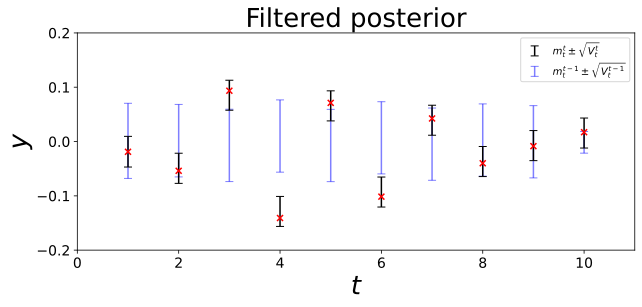

In [9]:
mf, Vf, S = filtering_pass(y, m0, S0, C, R, A, Q)

y_m_filt = np.dot(C, mf.T).T
y_v_filt = np.swapaxes(np.dot(C, np.dot(Vf, C.T)), 0, 1) + R
y_m_pred = np.dot(C, np.dot(A, mf.T)).T
y_v_pred = np.swapaxes(np.dot(C, np.dot(S, C.T)), 0, 1) + R

plt.figure(figsize=(10, 4))

plt.scatter(np.arange(1, num_points + 1),
            y[:, 0],
            marker='x',
            color='red',
            zorder=3)

plt.errorbar(x=np.arange(1, num_points + 1),
             y=y_m_filt[:, 0],
             yerr=y_v_filt[:, 0, 0] ** 0.5,
             color='black',
             zorder=2,
             fmt="none",
             label=r"$m_t^t \pm \sqrt{V_t^t}$",
             capsize=4)

plt.errorbar(x=np.arange(1, num_points + 1),
             y=y_m_pred[:, 0],
             yerr=y_v_pred[:, 0, 0] ** 0.5,
             color='blue',
             zorder=1,
             fmt="none",
             label=r"$m_t^{t - 1} \pm \sqrt{V_t^{t - 1}}$",
             capsize=4,
             alpha=0.5)

plt.title('Filtered posterior', fontsize=26)
plt.xticks(np.arange(0, num_points + 1, 2), fontsize=14)
plt.yticks(np.linspace(-0.2, 0.2, 5), fontsize=14)

plt.xlim([0, num_points + 1])
plt.ylim([-0.2, 0.2])

plt.xlabel(r'$t$', fontsize=26)
plt.ylabel(r'$y$', fontsize=26)

plt.legend()

plt.show()

### The smoothing pass

Similarly to the filtered distribution, we can derive the mean $\mathbf{m}_t^T$, variance $\mathbf{V}_t^T$ and covariance $V_{t+1, t}^T$ using Bayes' rule and the independence assumptions:

$$\begin{align}
\log p(\mathbf{x}_{t + 1}, \mathbf{x}_{t} | \mathbf{y}_{1:T}) &= \log p(\mathbf{x}_{t} | \mathbf{x}_{t + 1}, \mathbf{y}_{1:T}) + \log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:T}) \\
&= \log p(\mathbf{x}_{t} | \mathbf{x}_{t + 1}, \mathbf{y}_{1:t}) + \log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:T}) \\
&= \log p(\mathbf{x}_{t + 1} | \mathbf{x}_{t}, \mathbf{y}_{1:t}) + \log p(\mathbf{x}_{t} | \mathbf{y}_{1:t}) - \log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:t}) + \log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:T}) \\
&= \log p(\mathbf{x}_{t + 1} | \mathbf{x}_{t}) + \log p(\mathbf{x}_{t} | \mathbf{y}_{1:t}) - \log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:t}) + \log p(\mathbf{x}_{t + 1} | \mathbf{y}_{1:T}) \\
\end{align}$$

All these terms are quadratic forms so their sum is also a quadratic form. By comparing the expression{cite}`kalmanderivation` for a general quadratic from with the one above, we can recover the mean vector $\mathbf{m}_t^T$, the variance matrix $\mathbf{V}_t^T$ and the state covariance matrix $\mathbf{V}_{t+1,t}^T$, as given below.

<div class="theorem">
    
**Result (Kalman smoothing equations)** Given the linear state space model specified above, and the observed data $\mathbf{y}_{1:T}$, the mean $\mathbf{m}_t^T$, variance $\mathbf{V}_t^T$ and covariance $V_{t+1, t}^T$ of the smoothed posterior satisfy
    
$$\begin{align}
\mathbf{m}_t^T &= \mathbf{m}_t^t + \mathbf{J}_t(\mathbf{m}_{t + 1}^T - \mathbf{A}\mathbf{m}_t^t), \\
\mathbf{V}_t^T &= \mathbf{V}_t^t + \mathbf{J}_t (\mathbf{V}_{t + 1}^T - \mathbf{V}_{t + 1}^t) \mathbf{J}_t^\top, \\
\mathbf{V}_{t+1,t}^T &= \mathbf{V}_{t+1}^T \mathbf{J}_t^\top, \\
\mathbf{J}_t &= \mathbf{V}_t^t \mathbf{A}^\top (\mathbf{V}_{t+1}^t)^{-1}.\\
\end{align}$$ 
    
</div>
<br>

Below is an implementation of the filtering pass, computing $\mathbf{m}_t^t$ and $\mathbf{V}_t^t$ for $t = 1, 2, ..., T$.

In [10]:
def smooth_backward(y, mf, Vf, S, A, Q, C, R):
    
    T = y.shape[0]
    ms = np.zeros(shape=(T, 3))
    Vs = np.zeros(shape=(T, 3, 3))
    CV = np.zeros(shape=(T - 1, 3, 3))
        
    # Last-time smoothed posterior is equal to last-time filtered posterior
    ms[-1, :] = mf[-1, :]
    Vs[-1, :, :] = Vf[-1, :, :]
        
    # Smoothing steps
    for i in range(T - 2, -1, -1):
        
        J = np.linalg.solve(S[i], np.dot(A, Vf[i])).T
        
        Vs[i] = Vf[i] + np.dot(J, np.dot(Vs[i+1] - S[i], J.T))
        ms[i] = mf[i] + np.dot(J, ms[i+1] - np.dot(A, mf[i]))
        CV[i] = np.dot(Vs[i+1], J.T)
        
    return ms, Vs, CV

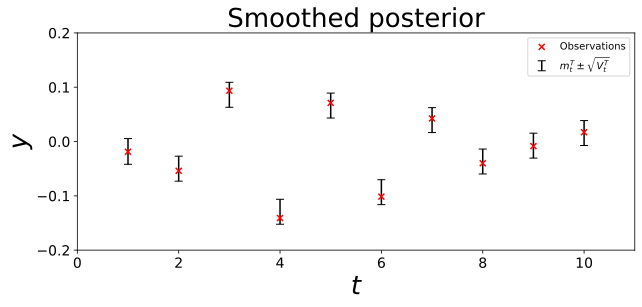

In [11]:
# Do the smoothing step
ms, Vs, _ = smooth_backward(y, mf, Vf, S, A, Q, C, R)

# Smoothed posterior over y
y_m_smooth = np.dot(C, ms.T)[0, :]
y_v_smooth = np.dot(C, np.dot(Vs, C.T) + R)[0, :, 0]

# Plot results
plt.figure(figsize=(10, 4))

# Plot the observed data y
plt.scatter(np.arange(1, num_points + 1),
            y[:, 0],
            marker='x',
            color='red',
            zorder=3, 
            label='Observations')

plt.errorbar(x=np.arange(1, num_points + 1),
             y=y_m_smooth,
             yerr=y_v_smooth ** 0.5,
             color='black',
             zorder=1,
             fmt="none",
             label=r"$m_t^{T} \pm \sqrt{V_t^{T}}$",
             capsize=4)

plt.title('Smoothed posterior', fontsize=26)
plt.xticks(np.arange(0, num_points + 1, 2), fontsize=14)
plt.yticks(np.linspace(-0.2, 0.2, 5), fontsize=14)

plt.xlim([0, num_points + 1])
plt.ylim([-0.2, 0.2])

plt.xlabel(r'$t$', fontsize=26)
plt.ylabel(r'$y$', fontsize=26)

plt.legend()

plt.show()

## Conclusion and extensions

This page presented the Kalman filtering and smoothing equations for a time invariant system. These can be straightforwadly extended to allow $\mathbf{A}$, $\mathbf{Q}$, $\mathbf{C}$ and $\mathbf{R}$ to depend on time. The equations then take exactly the same form, except these matrices are replaced by their time-dependent counterparts $\mathbf{A}_t$, $\mathbf{Q}_t$, $\mathbf{C}_t$ and $\mathbf{R}_t$. This algorithm assumes that these four matrices are known, however in practice this will often not be the case. In such a case, we can learn them from the data by maximising the marginal-likelihood, when tractable, or the EM algorithm{cite}`bishop` when the marginal likelihood is not tractable.

## References

```{bibliography} ./kalman.bib
```